# PET ROI SUV Statistics

This notebook will take in ROI files (NIfTI format) and calculate SUV statistics on the PET scan.

## Introduction

In this notebook, we will:
1. Load ROI files in NIfTI format.
2. Load the corresponding PET scan.
3. Calculate SUV statistics for the regions of interest.



## 1. Convert PET DICOM scans to NIFTI format

In [78]:
import dicom2nifti as d2n

PET_path = "/Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/SUV-P8ct_BS_40-60_2.3IT_4it_PSFoff"
output_path = "/Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/"

d2n.convert_directory(PET_path, output_path)

print(f'DICOM files from {PET_path} have been converted to NIfTI format and saved to {output_path}')

DICOM files from /Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/SUV-P8ct_BS_40-60_2.3IT_4it_PSFoff have been converted to NIfTI format and saved to /Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026


## 2. Load ROI files and convert PET scans to SUV values

In [1]:
import nibabel as nib
import numpy as np
import pydicom
import datetime
import os
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Upscale SUV values (256,256) to segmentation mask resolution (512,512)
def upscale_suv_values_3d(suv_values, new_shape):
    # Get the shape of the original SUV values array
    original_shape = suv_values.shape
    
    # Create arrays of coordinates for the original and new SUV values arrays
    x = np.linspace(0, 1, original_shape[0])
    y = np.linspace(0, 1, original_shape[1])
    z = np.linspace(0, 1, original_shape[2])
    
    new_x = np.linspace(0, 1, new_shape[0])
    new_y = np.linspace(0, 1, new_shape[1])
    new_z = np.linspace(0, 1, new_shape[2])
    
    # Create meshgrids of the coordinates
    x_mesh, y_mesh, z_mesh = np.meshgrid(x, y, z, indexing='ij')
    new_x_mesh, new_y_mesh, new_z_mesh = np.meshgrid(new_x, new_y, new_z, indexing='ij')
    
    # Interpolate the SUV values to the new coordinates in each dimension
    suv_interpolated = np.zeros(new_shape)
    for i in range(original_shape[2]):
        suv_interpolated[:, :, i] = interpolate.interpn((x, y), suv_values[:, :, i], (new_x_mesh[:, :, i], new_y_mesh[:, :, i]), method='linear', bounds_error=False, fill_value=None)
    
    return suv_interpolated

def load_nifti_file(filepath):
    """Load a NIfTI file and return the data array."""
    nifti_img = nib.load(filepath)
    data = nifti_img.get_fdata()
    return data

def convert_raw_PET_to_SUV(pet_dicom, pet_nifti):
    PET_data = load_nifti_file(pet_nifti)
    print(pet_dicom)
    full_path = os.path.join(pet_dicom, os.listdir(pet_dicom)[0])
    ds = pydicom.dcmread(full_path)
    
    # Get Scan time (Osirix uses SeriesTime, but can change to AcquisitionTime. Series time seems more precise)
    scantime = parse_time(ds.SeriesTime)
    # Start Time for the Radiopharmaceutical Injection
    injection_time = parse_time(ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime)
    # Half Life for Radionuclide # seconds
    half_life = float(ds.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife) 
    # Total dose injected for Radionuclide
    injected_dose = float(ds.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)
    
    # Calculate dose decay correction factor
    decay_correction_factor = np.exp(-np.log(2)*((scantime-injection_time).seconds)/half_life)

    
    patient_weight = ds.
    SUV_factor = (patient_weight) / (total_dose * decay_correction_factor)
    
    return(PET_data * SUV_factor)

def calculate_suv_statistics(roi_data, pet_data):
    """Calculate SUV statistics for each unique ROI."""
    unique_rois = np.unique(roi_data)
    suv_stats = {}
    
    for roi in unique_rois:
        if roi == 0:
            continue  # Skip the background
        roi_mask = roi_data == roi
        suv_values = pet_data[roi_mask]
        
        mean_suv = np.mean(suv_values)
        median_suv = np.median(suv_values)
        std_suv = np.std(suv_values)
        
        suv_stats[roi] = {
            'mean': mean_suv,
            'median': median_suv,
            'std': std_suv
        }
    return suv_stats

# Function to parse time with or without fractional seconds
def parse_time(time_str):
    try:
        # Try parsing with fractional seconds
        return datetime.datetime.strptime(time_str, '%H%M%S.%f')
    except ValueError:
        # Fallback to parsing without fractional seconds
        return datetime.datetime.strptime(time_str, '%H%M%S')

def visualize_array(array):
    # Define a function to plot a heatmap of a given layer
    def plot_heatmap(layer):
        plt.figure(figsize=(8, 6))
        plt.imshow(array[:, :, layer], cmap='viridis', origin='lower')
        plt.colorbar(label='Value')
        plt.title(f'Layer {layer}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

    # Use interact to create a slider for scrolling through layers
    interact(plot_heatmap, layer=IntSlider(min=0, max=array.shape[2] - 1, step=1, value=0))

In [3]:
nifti_path = "/Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/302_suv-p8ct_bs_40-60_23it_4it_psfoff.nii.gz"
dicom_path = "/Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/SUV-P8ct_BS_40-60_2.3IT_4it_PSFoff"

SUV_vals = convert_raw_PET_to_SUV(dicom_path, nifti_path)
SUV_vals.shape
array_range = np.ptp(SUV_vals)
print(array_range)

/Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/SUV-P8ct_BS_40-60_2.3IT_4it_PSFoff


NameError: name 'patient_weight' is not defined

$$
\text{decay\_correction\_factor} = \exp\left(-\ln(2) \cdot \frac{\text{{scantime}} - \text{{injection\_time}}}{\text{{half\_life}}}\right)
$$


## 3. Calculate SUV statistics within ROIs

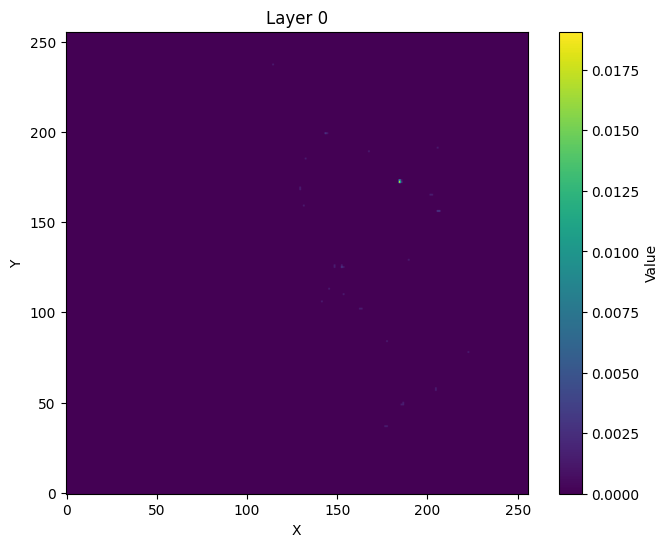

interactive(children=(IntSlider(value=0, description='layer', max=827), Output()), _dom_classes=('widget-inter…

In [97]:
visualize_array(SUV_vals)

In [91]:
segmentation_path = "/Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/segmentation1.nii"
segmentation_img = nib.load(segmentation_path)
segmentation_data = segmentation_img.get_fdata()

new_shape = (512, 512, segmentation_data.shape[2])

upscaled_suv_values = upscale_suv_values_3d(SUV_vals, new_shape)
print(upscaled_suv_values.shape)

stats = calculate_suv_statistics(segmentation_data, upscaled_suv_values)

# Convert array to a pandas DataFrame for better display
df = pd.DataFrame(stats)

# Display the DataFrame
display(df)

(512, 512, 828)


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,108.0,109.0,110.0,111.0,112.0,113.0,114.0,115.0,116.0,117.0
mean,0.816201,2.218232,0.770853,3.375697,1.276223,2.995071,2.635592,1.579427,1.661155,0.686801,...,0.676592,0.686799,0.936173,0.940037,0.650369,0.433225,0.463777,0.336334,1.265180,1.456310
median,0.793080,1.763944,0.705256,3.562352,1.100223,2.671892,2.826495,1.538411,1.606011,0.665961,...,0.486785,0.628322,0.762420,0.695548,0.516829,0.385168,0.359747,0.298564,0.799522,0.983471
std,0.363481,1.278214,0.426966,0.624017,0.761872,1.931598,1.061141,0.270805,0.404776,0.483304,...,0.592306,0.497242,0.939885,1.045145,0.700056,0.250183,0.273606,0.151981,1.189634,1.234656


In [82]:
segmentation_data.shape

(512, 512, 828)

In [83]:
SUV_vals.shape

(256, 256, 828)